<h1 align=center><b>2023 Principle of Data Analytics</b></h1>
<h1 align=center>Analysis of the Palmer Penguins Dataset</h1>
<h3 align=center>Guillermo F. Martin Gonzalez</h3>

**Table of contents**<a id='toc0_'></a>    
- [1. Introduction](#toc1_)    
  - [1.1 Hypothesis](#toc1_1_)    
- [2. Statistical analysis](#toc2_)
  - [2.1 Model Selection](#toc2_1_)  
  - [2.2 Model Interpretation](#toc2_2_)   
- [3. Bibliography](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [60]:
# Python packages used in the current notebook
import pandas as pd #import pandas library and name it pd
import numpy as np #import numpy library and name it np
import seaborn as sns #import seaborn library and name it sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# <a id='toc1_'></a>[1. Introduction](#toc0_)

After importing the data into our environment, we firstly visualize and try to understand the variables contained in the .csv file. The dataset contains a total of 7 columns. We can divide the columns in two main categories: 

* <u>Response variables</u>: four different variables related to biological traits, namely bill length (mm; length of the peak), bill depth (mm; depth of the peak), flipper length (mm) and body mass (gr). 
  
* <u>Covariates</u>: three columns which contain information about the sample itself such as the penguin specie (Adelie, Chinstrap, Gentoo), presumably the island (Torgersen,Biscoe, Dream) where the data was taken, the sex (MALE,FEMALE,nan) of the individual. Indivuals were the sex is unkown are categorised as nan.  

In [6]:
# Load the penguins dataset and have a first look at it
df = pd.read_csv("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv") # Load the data.
#df.head() # Look at the heading of the data
df.info() # Information about each column
#df.sex.unique()
#df.island.unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


Now, a good way of understanding the type of data we have in front and the potential correlations that are present is to do a correlation plot or pair plot. We will use the seaborn package to do so. This type of plot allows to colour the variables plotted based on the level of a different covariate, in this case, we will colour the variables based on the specie.  

The pairplot (Fig. 1) provides provides a combination of scatter plots and density plots. From the scatter plots, we can see that there is a very clear positive correlation (increse in X with increase in Y) across all the biological traits described previously.The density plots, provides information of how different the biological traits are based on each specie. For instance, we can see that the bill depth of the Gentoo penguins is smaller that the other two species (density further left), but body mass of the Gentoo penguins is larger (density further right) that the other two species, suggesting that the Gentoo penguins are a bigger specie (as confirmed by quickly looking at a height plot from the British Antarctic Survey; Fig. 12). This is not unexpected, as different species would usually display differences in biological traits.  

Text(0.5, 1.08, 'Penguin species pairplot')

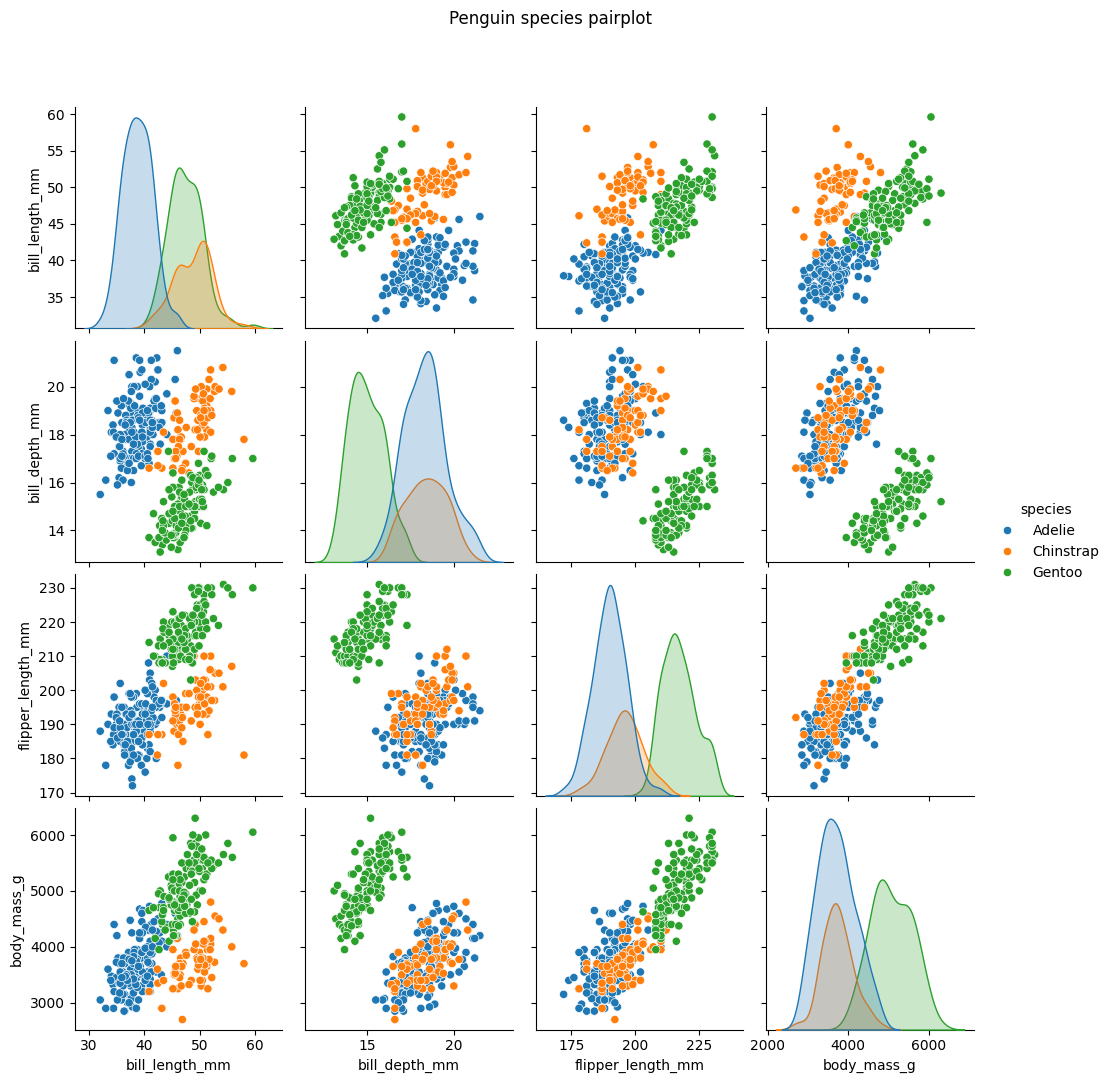

In [8]:
pp=sns.pairplot(df, hue="species")
pp.fig.suptitle("Figure 1: Penguin species pairplot", y=1.08)

<figure align=center>
    <img src="https://pbs.twimg.com/media/FJjMJMDX0AcONoE?format=jpg&name=900x900" alt="Alternative text">
    <figcaption>Figure 2: Height of Antartic penguins. Downloaded <a href="https://twitter.com/BAS_News/status/1484160541069357060">here</a>
    </figcaption>
</figure> 

Now, as we are interested in understanding the potential correlation around biological traits, and given that these traits are quite different across the species in the data, further analysis should really consider the species column as a covariate. Another covariate worth looking at might be the island where the data was taken from or the sex of each individual, as usually, within an specie, biologial traits display different characteristics (sexual dimorphism; <a href="https://www.jstor.org/stable/2408711">Slatkin, 1984</a>).  

The barplot (Figure 3) can be very useful in this regard. It is clear, that indeed, the gentoo penguins exhibit the smaller bill depth but are heavier than the other two species. Quite interestingly, although both bill depth and body mass is bigger in males than females (as we thought), the difference between sexes is more pronounced in the body mass! There could be many  reasons for this... I could hypothesize that males could be heavier as they have more protein content than females? Literature review is necessary...

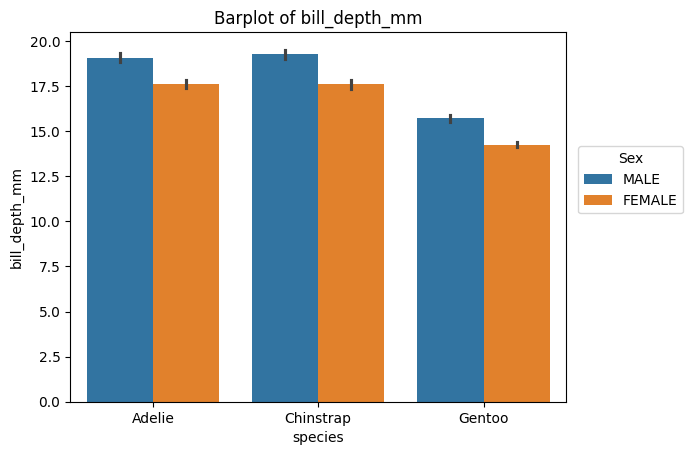

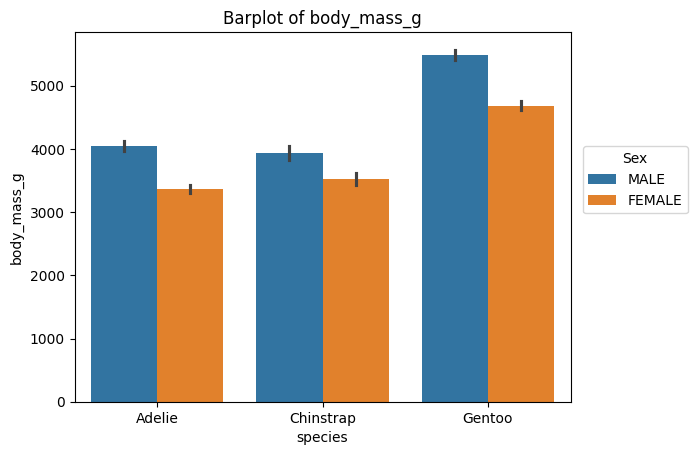

In [9]:
for c in ["bill_depth_mm","body_mass_g"]:
 plt.figure()
 sns.barplot(df,x="species",hue="sex",y=c)
 plt.legend(title="Sex",bbox_to_anchor=(1.25, 0.6), loc='center right')
 plt.title(f"Barplot of {c}")
 

## <a id='toc1_1_'></a>[1.1 Hypothesis](#toc0_)

As briefly discussed above, we will test two hypothesis: 
1. Penguin flipper length is positively correlated with body mass 

2. The relationship between these two biological traits vary across species (gentoo presenting the larger flipper lengths and body masses) and between sexes (flipper length and body mass will be larger in males than females). 

# <a id='toc2_'></a>[2. Statistical analysis](#toc0_)

Now that we have established our hypothesis, we will implement a simple linear model that predicts body mass as a linear function of bill depth, taking into account the penguin species and the sex of the individual. Now, in linear modelling frameworks, however, we can further ask: 

Do we expect significant differences in the relationship between bill depth and body mass depending on the specie or the sex? In other words, does the slope of body mass vs bill depth differs across sexes and/or species? This is what is called an interaction term. If we believe, that for instance body mass increases with bill depth with a similar slope across species, the interaction would be non-significant. However, if the slopes cross each other, this would be a significant interaction.

Following the methods described in Zuur et al., 2013, we will implement a series of models, from the most complex, and then drop interactions and terms once at a time. Then we will compare models using the Akaike Information Criterion (AIC), which allows to identify the most parsimonious models (Bozdogan, H., 1987)

In [56]:
#Drop NA values
df_cleaned=df.dropna(subset=['body_mass_g','bill_depth_mm', 'sex', 'species'])

formulas = [
    "body_mass_g ~ bill_depth_mm *  C(sex) * C(species)",
    "body_mass_g ~ bill_depth_mm * C(sex) + C(species)",
    "body_mass_g ~ bill_depth_mm * C(species) + C(sex)",
    "body_mass_g ~ bill_depth_mm + C(sex) + C(species)"
] #Looping over model formulas

penguin_models = []
aic=[]
for formula in formulas:
    model = smf.ols(formula=formula, data=df_cleaned).fit()
    penguin_models.append(model)
    aic.append(round(model.aic,2))

## <a id='toc2_1_'></a>[2.1 Model selection](#toc0_)

When using AIC for comparing models, the lower the AIC, the more parsimonius the model is. Now, if the difference between AIC values is small (usually a threshold of 3 units), we tend to chose the less complex model. This is because, it will help with its interpretation and also the number of parameters needed to be estimated will be smaller. In the models implemented above, and following these rule, the best model would be number 2. 

In [52]:
aic_table=pd.DataFrame({'Model Formula':formulas,
                        'AIC': aic})
pd.set_option('colheader_justify', 'center')
pd.set_option('display.max_colwidth', None)
print(aic_table)

                     Model Formula                       AIC  
0  body_mass_g ~ bill_depth_mm *  C(sex) * C(species)  4748.97
1   body_mass_g ~ bill_depth_mm * C(sex) + C(species)  4751.08
2   body_mass_g ~ bill_depth_mm * C(species) + C(sex)  4754.27
3   body_mass_g ~ bill_depth_mm + C(sex) + C(species)  4760.70


## <a id='toc2_2_'></a>[2.2 Model Interpretation](#toc0_)

The summary of the model provides very important information. Our reference level is female Adelie penguins. 

In [59]:
print(penguin_models[1].summary())

                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     410.9
Date:                Tue, 02 Apr 2024   Prob (F-statistic):          1.29e-138
Time:                        21:45:13   Log-Likelihood:                -2369.5
No. Observations:                 333   AIC:                             4751.
Df Residuals:                     327   BIC:                             4774.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

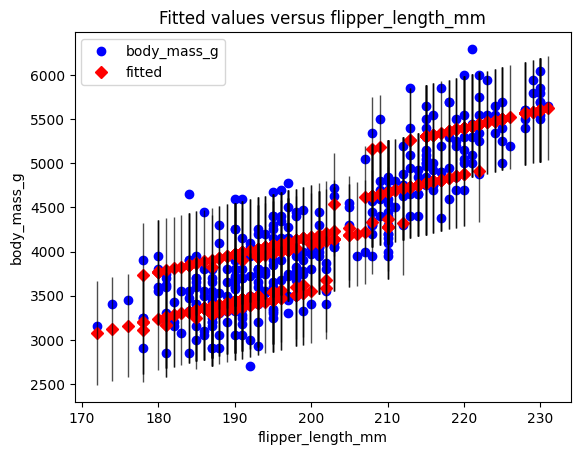

In [77]:
#fig = sm.graphics.plot_fit(penguin_model, "flipper_length_mm")

# <a id='toc3_'></a>[3. Bibliography](#toc0_)

Bozdogan, H., 1987. Model selection and Akaike's information criterion (AIC): The general theory and its analytical extensions. Psychometrika, 52(3), pp.345-370.

Zuur, A.F., Hilbe, J.M. and Ieno, E.N., 2013. A Beginner’s Guide to GLM and GLMM with R, Beginner’s Guide Series. Newburgh: Highland Statistics Limited, 105.